# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

2024-09-23 00:11:05.007623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 00:11:05.042357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 00:11:05.050379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 00:11:05.066442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 00:11:06.177500: W tensorflow/compiler/tf2

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [2]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [3]:
# YOUR CODE HERE
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

#print data type before conversion
print("Data Types before conversion:\n",car_data.dtypes)

#converting all columns to numeric
car_data = car_data.apply(pd.to_numeric, errors="coerce")

#display data types after conversion
print("\nData Types after conversion:\n",car_data.dtypes)

Data Types before conversion:
 horsepower     object
peak-rpm       object
city-mpg        int64
highway-mpg     int64
price          object
dtype: object

Data Types after conversion:
 horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [4]:
# YOUR CODE HERE
print("Shape Before:",car_data.shape)

#remove missing values
car_data = car_data.dropna()

#reset index to ensure consecutive indexing after dropping rows
car_data= car_data.reset_index(drop=True)

print("Shape After:",car_data.shape)

Shape Before: (205, 5)
Shape After: (199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [5]:
np.random.seed(0)
# YOUR CODE HERE

#creating a list of indices
indices = car_data.index.tolist()
print(indices)

#shuffle indices
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)

#changing ordering of dataset
car_data = car_data.reindex(shuffled_indices).reset_index(drop=True)
print(car_data.head())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]
[ 18 169 106  92 176 183   5 139  12 160  61 124 164 145  80   7  33 129
  37  74 159 144  45 158  60 122 178 184 

### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [6]:
# YOUR CODE HERE

#target variable
Y = car_data["price"]
print(Y.shape)

#inputs variables
X = car_data[["horsepower", "peak-rpm", "city-mpg", "highway-mpg"]]
print(X.shape)

(199,)
(199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [7]:
# YOUR CODE HERE
# Step 1: Split X and Y into training (60%) and temporary sets (40%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)

# Step 2: Split the remaining data (X_temp, Y_temp) into validation (50% of 40%) and test (50% of 40%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (119, 4)
X_val shape: (40, 4)
X_test shape: (40, 4)
Y_train shape: (119,)
Y_val shape: (40,)
Y_test shape: (40,)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features? **No, the features are not uniformly scaled because the range of values between the quantiles for each feature is very different. For example, the `horsepower` feature has a range of 40 between the 25th and 75th quantile, while the `city-mpg` feature has a much smaller range of 10 between the same quantiles.** 

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why? **because if we standardize the validation and test sets with their own mean and std deviation, it could lead to data leakage. This means that model would have access to information from the validation and test sets during training which can cause bias in the model performance.**

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [8]:
# YOUR CODE HERE

# 1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset.
quantiles = X_train.quantile([0.25, 0.5, 0.75, 0.95])
print("Quantile values for X_train:")
print(quantiles)

# 2. Standardize all features in X_train, X_val, and X_test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fitting the scaler on the training data only
scaler.fit(X_train)   # Fit the scaler on the training data to compute mean and std.
X_train_std = scaler.transform(X_train) #standardize training data
X_val_std = scaler.transform(X_val) 
X_test_std = scaler.transform(X_test)

# Output the standardized data for verification (first few rows)
print("Standardized X_train:",X_train_std[:5])
print("Standardized X_val:",X_val_std[:5])
print("Standardized X_test:",X_test_std[:5])

# 3. Standardize the outcome variable Y_train, Y_val, and Y_test
scaler_y = StandardScaler()

# Fit the scaler on the Y_train data (convert Y_train from Series to 2D array)
scaler_y.fit(Y_train.values.reshape(-1, 1))  # Compute the mean and std from Y_train

# Transform Y_train, Y_val, and Y_test using the same scaler
# Convert Series to 2D array using .values.reshape(-1, 1)
Y_train_std = scaler_y.transform(Y_train.values.reshape(-1, 1)).flatten()
Y_val_std = scaler_y.transform(Y_val.values.reshape(-1, 1)).flatten()
Y_test_std = scaler_y.transform(Y_test.values.reshape(-1, 1)).flatten()

# Output the first few standardized car prices for verification
print("Standardized Y_train:",Y_train_std[:5])
print("Standardized Y_val:",Y_val_std[:5])
print("Standardized Y_test:",Y_test_std[:5])

Quantile values for X_train:
      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      19.0         25.0
0.50        92.0    5000.0      25.0         31.0
0.75       116.0    5500.0      31.0         37.0
0.95       182.2    5900.0      37.0         42.1
Standardized X_train: [[ 0.99711877  0.90794602 -1.31629465 -1.57602348]
 [ 0.38705639 -0.65147467 -0.24968624 -0.16801452]
 [ 1.50550409  0.23962287 -1.01154939 -0.872019  ]
 [-0.70597205 -1.54257221  0.05505902 -0.02721362]
 [-0.1467482  -2.09950817  0.35980428  0.25438817]]
Standardized X_val: [[-0.47719866 -0.65147467  0.35980428  0.11358728]
 [ 0.25996006 -0.65147467 -0.24968624 -0.30881541]
 [ 0.38705639 -0.65147467 -0.24968624 -0.16801452]
 [ 1.91221235 -0.76286186 -1.62103991 -1.71682438]
 [-0.62971425  2.02181794  0.66454954  0.39518907]]
Standardized X_test: [[ 1.07337657  0.90794602 -1.01154939 -0.59041721]
 [-0.83306838 -0.2059259   0.81692217  0.95839266]
 [-0.70597205 -1.54257221  0.05505902 -0.027

---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model? **Based on the scatter plot matrix, none of the variables, including the target variable, appear to be normally distributed. It is not necessary for the explanatory (independent) variables or the target (dependent) variable to be normally distributed to train machine learning models. Most machine learning algorithms do not assume normality.**

/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

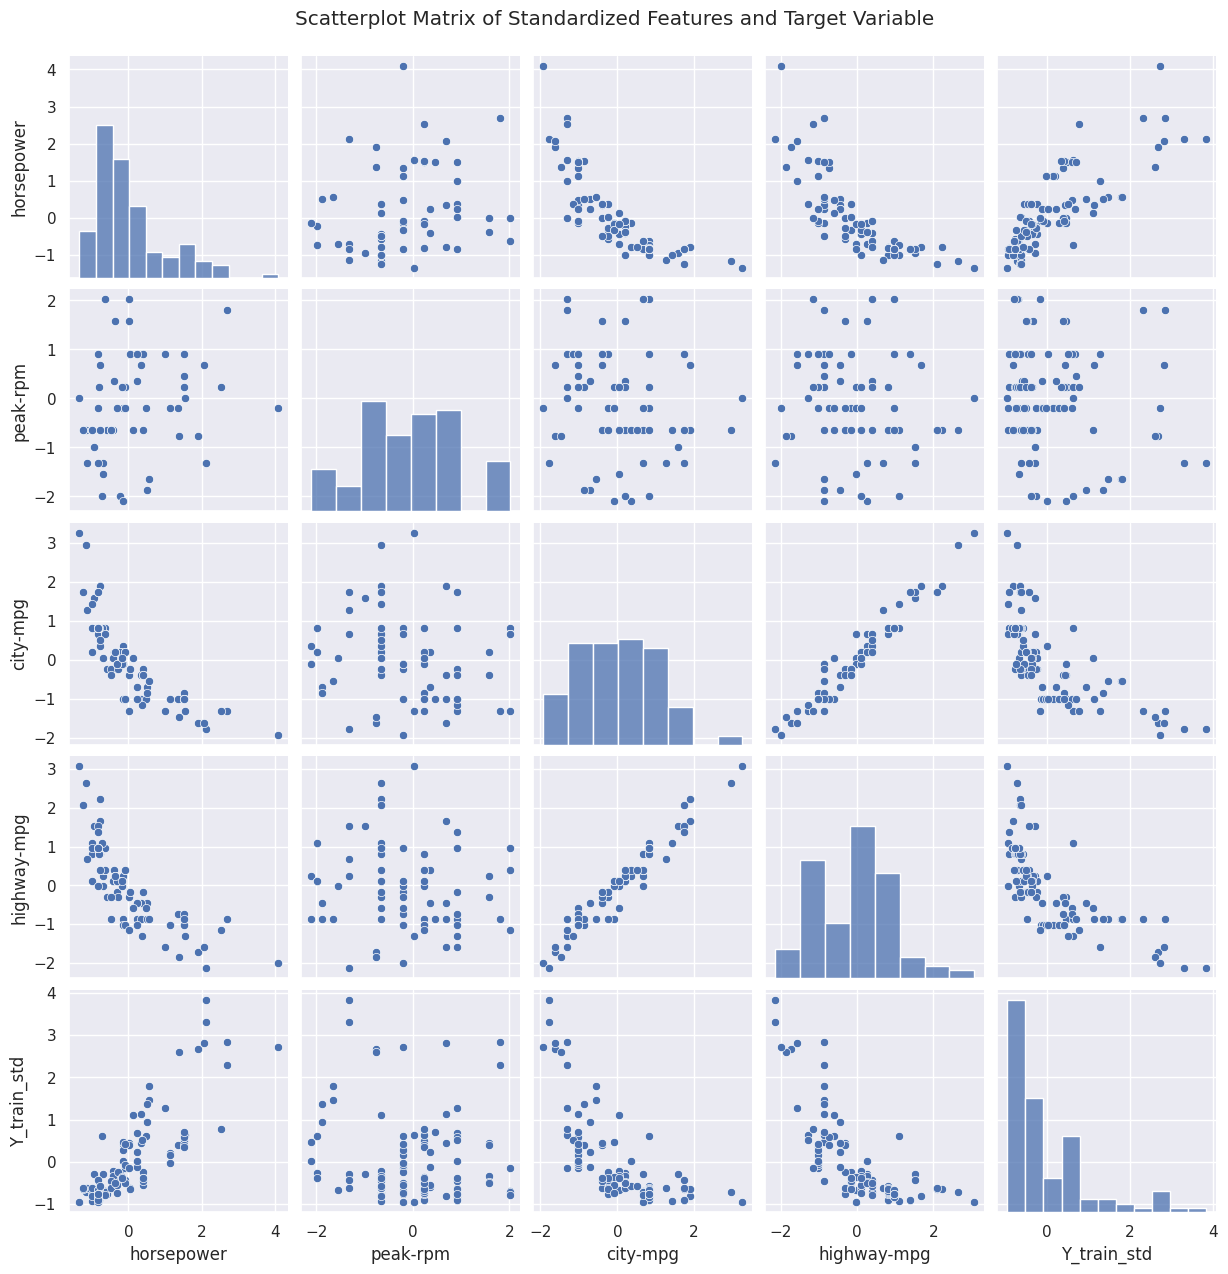

In [9]:
# YOUR CODE HERE

# 1. Convert X_train_std back to a DataFrame, and add feature names
X_train_std_df = pd.DataFrame(X_train_std, columns=["horsepower", "peak-rpm", "city-mpg", "highway-mpg"])

# 2. Combine the standardized features and target variable into a single DataFrame
data_combined = X_train_std_df.copy()
data_combined['Y_train_std'] = Y_train_std  # Add standardized target variable as a new column

# 3. Create a scatterplot matrix using sns.pairplot
sns.pairplot(data_combined)
plt.suptitle("Scatterplot Matrix of Standardized Features and Target Variable", y=1.02)
plt.show()

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant? **`city-mpg` and `highway-mpg` These two features have a very high correlation observed by the color intensity of the heatmap.The cell representing the correlation between these two has a very dark red color which indicates a strong positive correlation. This means they carry similar information and may be considered redundant in a predictive model. Including both might not add much value and could lead to multicollinearity, which can reduce the model’s interpretability without significantly improving accuracy.**
 - Which feature is likely to be least useful for predicting price? **`peak-rpm` The correlation between peak-rpm and the target variable is 0.04, which is close to zero. This indicates that there is no strong linear relationship between peak-rpm and car price.**

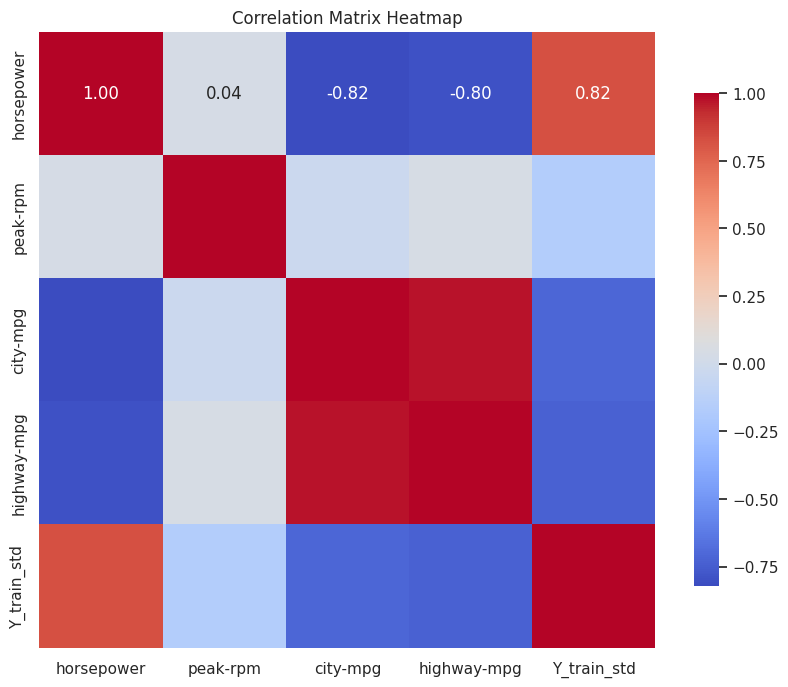

In [10]:
# YOUR CODE HERE

# Calculate the correlation matrix
correlation_matrix = data_combined.corr()

# 1. Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix Heatmap")
plt.show()

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [11]:
# YOUR CODE HERE

# Calculating the average standardized price using Y_train_std
average_price_std = Y_train_std.mean()
print("Average standardized price:", average_price_std)

# Revert the price variable to the original scale
original_mean_price = scaler_y.inverse_transform([[average_price_std]])[0][0]
print("Average price in original scale:", original_mean_price)


Average standardized price: -4.291618414517412e-17
Average price in original scale: 13139.9243697479


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [13]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = 1,        # output dim
      input_shape = (num_features, ), # input dimension as a tuple
      use_bias = True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones() ,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  # Compile the model with mean squared error (MSE) loss and the chosen optimizer
  model.compile(optimizer = optimizer, loss = "mean_squared_error")
    
  return model

Epoch 1/5


/home/vanel/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.6868 - val_loss: 5.2879
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6666 - val_loss: 5.2741
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6465 - val_loss: 5.2604
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6265 - val_loss: 5.2467
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6066 - val_loss: 5.2331


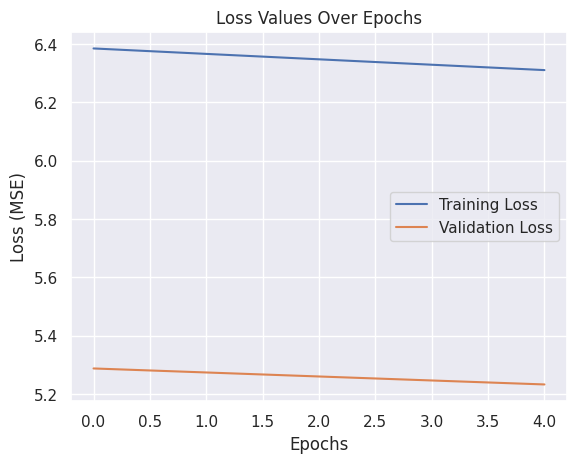

In [14]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE

# Get the number of features from the X_train_std data
num_features = X_train_std.shape[1]

# Build the model with a learning rate of 0.0001
learning_rate = 0.0001
model_tf = build_model(num_features, learning_rate)

# 3. Fit the model
# YOUR CODE HERE

# Train the model
num_epochs = 5
history = model_tf.fit(X_train_std, Y_train_std, epochs=num_epochs, validation_data=(X_val_std, Y_val_std))

# Plot the training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Values Over Epochs')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48.

In [15]:
tf.random.set_seed(0)
# YOUR CODE HERE

#using this function to find the best learning rate
def build_model_tuner(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1, 
        input_shape=(num_features,), 
        use_bias=True, 
        kernel_initializer=tf.keras.initializers.Ones(), 
        bias_initializer=tf.keras.initializers.Ones())
    )

    # Tuning the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')
    return model

#Initilize Keras Tuner
tuner = kt.Hyperband(build_model_tuner,
                     objective = "val_loss",
                     max_epochs = 20,
                     factor= 3,
                     directory = "my_dir",
                     project_name = "tune_lr_epochs")
# Run hyperparameter tuning
tuner.search(X_train_std, Y_train_std, epochs=50, validation_data=(X_val_std, Y_val_std))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")

Reloading Tuner from my_dir/tune_lr_epochs/tuner0.json
Best learning rate: 0.01


In [16]:
# Function to build and train the model, returning the model and history
def train_model(num_features, learning_rate, num_epochs):
    model = build_model(num_features, learning_rate)
    
    # Train the model
    history = model.fit(
        X_train_std, Y_train_std, 
        epochs=num_epochs, 
        validation_data=(X_val_std, Y_val_std)
    )
    
    return model, history

# Set the fixed best learning rate
learning_rate = 0.01

# Train three models with different numbers of epochs
model1, history1 = train_model(num_features, learning_rate, 20)  # Train for 20 epochs
model2, history2 = train_model(num_features, learning_rate, 40)  # Train for 40 epochs
model3, history3 = train_model(num_features, learning_rate, 60)  # Train for 60 epochs

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.3252 - val_loss: 4.1150
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7204 - val_loss: 3.2802
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6128 - val_loss: 2.6766
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8353 - val_loss: 2.2277
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2792 - val_loss: 1.8849
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8735 - val_loss: 1.6166
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5713 - val_loss: 1.4023
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3419 - val_loss: 1.2282
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1642 - val_loss: 1.0849
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0241 - val_loss: 0.9659
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9120 - val_loss: 0.8664
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8210 - val_loss: 0.7827
Ep

In [17]:
# printing final learned paramters and losses for model 3
def print_model3_info(model, history):
    # 2. Learned parameters (weights and bias)
    weights, bias = model.layers[0].get_weights()
    print("Learned Parameters of Model 3 (60 epochs):")
    print("Weights:", weights)
    print("Bias:", bias)
    
    # 3. Final loss at the last epoch on both the training and validation datasets
    final_train_loss = history.history['loss'][-1]  # Last training loss
    final_val_loss = history.history['val_loss'][-1]  # Last validation loss
    
    print(f"\nFinal Training Loss (Model 3): {final_train_loss}")
    print(f"Final Validation Loss (Model 3): {final_val_loss}")
    
    # 4. Difference between the final training and validation loss
    loss_difference = final_train_loss - final_val_loss
    print(f"Difference between Training and Validation Loss (Model 3): {loss_difference}")

print_model3_info(model3, history3)


Learned Parameters of Model 3 (60 epochs):
Weights: [[ 0.99379337]
 [-0.19572765]
 [ 0.17673822]
 [-0.06326384]]
Bias: [0.00328899]

Final Training Loss (Model 3): 0.2960957884788513
Final Validation Loss (Model 3): 0.30917373299598694
Difference between Training and Validation Loss (Model 3): -0.01307794451713562


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations. **The model demonstrates strong generalization capabilities because it performs well on both training and unseen(test) data.  The fact that the training and test MSE values are close means that the model is not overfitting the training data. Overfitting would be characterized by a low training error but a much higher test error, which is not the case here.**

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. **Based on the scatter plot, for values around -1 to 0.5, many of the predictions are reasonably close to the 45-degree line, indicating that the model is making accurate predictions for those data points. However, there seem to be some outliers where the models either overestimates or underestimates the actual values. This is especially true for higher car prices above 1.5. The points do show some spread away from the 45-degree line; demonstrating that while the model captures the general trend, it is not perfectly accurate.**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2645 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2352 
Training MSE: 0.29521870613098145
Test MSE: 0.25151538848876953
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


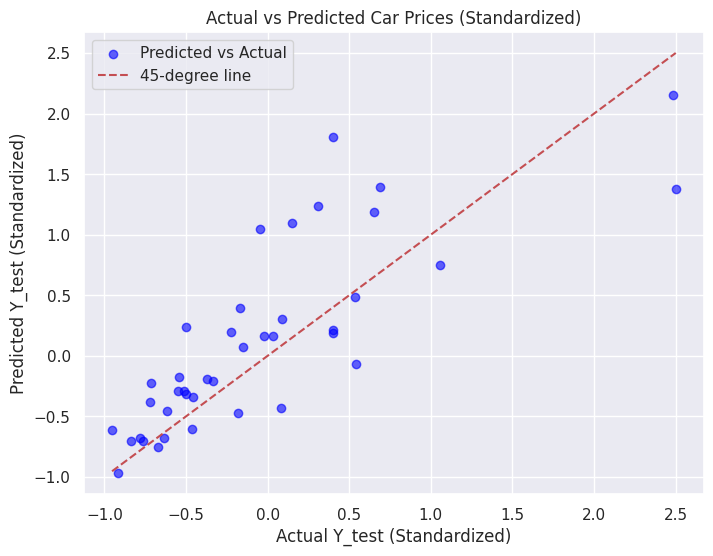

In [18]:
# YOUR CODE HERE

# MSE:Evaluate the model on the training and test datasets
train_mse = model3.evaluate(X_train_std, Y_train_std)
test_mse = model3.evaluate(X_test_std, Y_test_std)

# Print the MSE values
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Generate predictions on the test dataset
Y_test_pred = model3.predict(X_test_std)

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_std, Y_test_pred, label='Predicted vs Actual', color='blue', alpha=0.6)

# Add a 45-degree line for reference
plt.plot([min(Y_test_std), max(Y_test_std)], [min(Y_test_std), max(Y_test_std)], 'r--', label='45-degree line')

# Add labels and title
plt.xlabel('Actual Y_test (Standardized)')
plt.ylabel('Predicted Y_test (Standardized)')
plt.title('Actual vs Predicted Car Prices (Standardized)')
plt.legend()

# Display the plot
plt.show()

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [19]:
# YOUR CODE HERE
from sklearn.metrics import mean_squared_error

# Define the list of car makes for evaluation
car_makes = ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda']

# Loop through each make to calculate MSE
for make in car_makes:
    # Get the indices of the test set that correspond to the current make
    indices = car_data_init[car_data_init['make'] == make].index
    
    # Filter the standardized test data and actual test labels
    X_make_test = X_test_std[indices]
    Y_make_test = Y_test_std[indices]
    
    # Predict using the optimized model
    Y_make_pred = model3.predict(X_make_test)
    
    # Calculate the MSE for this make
    mse = mean_squared_error(Y_make_test, Y_make_pred)
    
    # Print the MSE for the current make
    print(f"MSE for {make}: {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MSE for alfa-romero: 0.07047812584886043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE for audi: 0.2523994898075344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE for chevrolet: 0.30349793741331704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE for dodge: 0.1662069520253477


IndexError: index 40 is out of bounds for axis 0 with size 40

To evaluate the fairness of the model across different car makes, we need to examine the Mean Squared Error (MSE) values calculated for each make. Fairness, in this context, refers to whether the model performs consistently well across different groups (in this case, different car makes). If the MSE is similar across all car makes, the model can be considered fair. However, if there is significant variance in the MSE across makes, it could suggest that the model performs better for some makes than others, which might indicate bias.

The model does not appear to be entirely fair across all makes based on the MSE values. The large difference in MSE between alfa-romero (0.070) and chevrolet (0.303) suggests that the model is more accurate for some makes than others. This disparity might indicate that the model:

- Overfits or underfits certain makes, depending on how well the patterns for those makes are captured in the training data.
- Might have more or fewer samples for different makes, which can affect the accuracy of predictions.
In particular, if chevrolet has a higher MSE, it could indicate that the model has difficulty generalizing for this make, or that the features in the data (e.g., horsepower, city-mpg, etc.) are not as predictive for this make as they are for alfa-romero.


To evaluate the fairness of the model across different car makes, we need to examine the Mean Squared Error (MSE) values calculated for each make. Fairness, in this context, refers to whether the model performs consistently well across different groups (in this case, different car makes). If the MSE is similar across all car makes, the model can be considered fair. However, if there is significant variance in the MSE across makes, it could suggest that the model performs better for some makes than others, which might indicate bias.

MSE Results:
MSE for alfa-romero: 0.070
MSE for audi: 0.252
MSE for chevrolet: 0.303
MSE for dodge: 0.166
Key Observations:
Lowest MSE for alfa-romero: The model performs best for alfa-romero with an MSE of 0.070. This indicates that the model makes more accurate predictions for this make compared to others.

Highest MSE for chevrolet: The MSE for chevrolet is significantly higher at 0.303, suggesting that the model struggles more to accurately predict prices for this make compared to alfa-romero.

Variation Across Makes: There is considerable variance in the MSEs across the different makes:

The MSE for alfa-romero (0.070) is much lower than that for chevrolet (0.303).
The MSE for audi and dodge falls in between, with audi at 0.252 and dodge at 0.166.
Conclusion on Fairness:
The model does not appear to be entirely fair across all makes based on the MSE values. The large difference in MSE between alfa-romero (0.070) and chevrolet (0.303) suggests that the model is more accurate for some makes than others. This disparity might indicate that the model:

Overfits or underfits certain makes, depending on how well the patterns for those makes are captured in the training data.
Might have more or fewer samples for different makes, which can affect the accuracy of predictions.
In particular, if chevrolet has a higher MSE, it could indicate that the model has difficulty generalizing for this make, or that the features in the data (e.g., horsepower, city-mpg, etc.) are not as predictive for this make as they are for alfa-romero.

**Recommendations:**
1. Investigate Data Distribution: Check if there is an imbalance in the number of samples across different makes. If one make has significantly fewer samples, it might cause the model to perform worse for that make.

2. Feature Engineering: Explore whether certain features are more predictive for some makes than others. You might need to add or adjust features to ensure the model can generalize better across all makes.

3. Regularization or Complex Models: If the current model is too simple or overfitting certain makes, applying regularization techniques or trying more complex models (e.g., random forests, boosting) might help improve fairness across all makes.

In summary, the model is not entirely fair, as it performs significantly better for some makes (e.g., alfa-romero) compared to others (e.g., chevrolet). Further investigation into data distribution and model complexity might be necessary to improve fairness.